
# Introduction

Author : Charles Le Losq.

This notebook tests the relationship between problem complexity, size of neural networks, size of the training set and interpolation/extrapolation abilities.

According to the Deep Learning Book (google it!), latest research show that deep neural networks with Relu units perform well in term of generalisation, and overall are better than shallow network with more units per layer.

Can this be verified on small datasets, with only a few hundreds of training points and not uniformaly distributed?

We will study this using the rampy mlregressor function. As described below, it is a convenient high-level API to scikit-learn.

In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import rampy as rp

from sklearn.metrics import mean_squared_error

np.random.seed(42) # fixing random seed

# Data generation

We define a function to explore, preferentially a strongly non-linear one.

In [2]:
def f2(x):
    return 0.1*x + 800*np.cos(x/15) - 1/60*x**2

Now I generate sparse data with this function, with a bit of noise.

In total we have 2000 datapoints


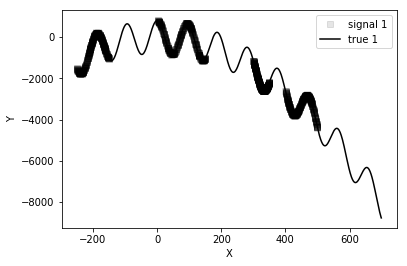

In [9]:
a = 1.
b = 150.
n_sub = 500

x1 = (-150 - -50) * np.random.random_sample(n_sub) + -150
x2 = (b - a) * np.random.random_sample(n_sub) + a
x3 = (500.0 - 400.0) * np.random.random_sample(n_sub) + 400.0
x4 = (350.0 - 300.0) * np.random.random_sample(n_sub) + 300.0

x = np.sort(np.concatenate((x1,x2,x3,x4)))

y = f2(x)

noise = 20*np.random.randn(len(x))

y_noisy = y+noise

X_interp = np.arange(-200,700)

plt.plot(x,y_noisy,"ks",alpha=0.1,label="signal 1")
plt.plot(X_interp,f2(X_interp),"k-",label="true 1")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")

print("In total we have %i datapoints" % len(x))

In the following we use the mlregressor class of the rampy library for convenience, which is a high-level API to the scikit-learn algorithms.

It automatically scale the data as well as split them in train-testing subsets.

I will post in the future a low-level version using Flux.jl in the Julia language to compare performance.

The first model is a one-layer network with 100 units and tanh activation functions. Problem is solved with the lbfgs solver. This will be an "historical" neural net.

In [10]:
model1 =rp.mlregressor(x.reshape(-1, 1),y_noisy.reshape(-1, 1))
model1.scaler = 'StandardScaler'
model1.param_neurons['hidden_layer_sizes'] = (100,) 
model1.param_neurons['activation'] = "tanh"
model1.algorithm = "NeuralNet"
model1.param_neurons['solver'] = "lbfgs"
model1.fit()

The second network is a deep one, 5 layers of 100 neurons, with relu activation function. We still use lbfgs for optimization as the dataset is (on purpose) small.

In [11]:
model2_deep =rp.mlregressor(x.reshape(-1, 1),y_noisy.reshape(-1, 1))
model2_deep.scaler = 'StandardScaler'
model2_deep.algorithm = 'NeuralNet'
model2_deep.param_neurons['hidden_layer_sizes'] = (100,100,100,100,100) 
model2_deep.param_neurons['activation'] = "relu"
model2_deep.param_neurons['solver'] = "lbfgs"
model2_deep.param_neurons['max_iter']=10000
model2_deep.fit()

And the first model is a simple kernel ridge regression algorithm. Rampy performs automatic hyperparameter tuning, so we don't need to do too much there.

In [12]:
model3_krr =rp.mlregressor(x.reshape(-1, 1),y_noisy.reshape(-1, 1))
model3_krr.scaler = 'StandardScaler'
model3_krr.algorithm = 'KernelRidge'
model3_krr.fit()

And we plot the result for final comparison. Which one is the best????

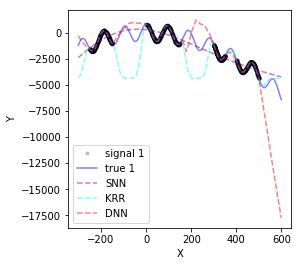

In [13]:
X_interp = np.arange(-300,600)

plt.figure(figsize=(4,4))

plt.plot(x,y+noise,"k.",alpha=0.2,label="signal 1")

plt.plot(X_interp,f2(X_interp),"b-",alpha=0.5,label="true 1")

plt.plot(X_interp,model1.predict(X_interp.reshape(-1,1)),"--",alpha=0.5,color="purple",label="SNN")
plt.plot(X_interp,model3_krr.predict(X_interp.reshape(-1,1)),"--",alpha=0.5,color="cyan",label="KRR")
plt.plot(X_interp,model2_deep.predict(X_interp.reshape(-1,1)),"r--",alpha=0.5,label="DNN")

plt.xlabel("X")
plt.ylabel("Y")

#plt.ylim(-500,300)

plt.legend()

In [14]:
print("Mean squared errors for the shallow and deep networks and the KRR algorithm are: ")
print(mean_squared_error(model1.predict(x.reshape(-1, 1)),y))
print(mean_squared_error(model2_deep.predict(x.reshape(-1, 1)),y))
print(mean_squared_error(model3_krr.predict(x.reshape(-1, 1)),y))

Mean squared errors for the shallow and deep networks and the KRR algorithm are: 
216686.2451205452
1063.5047112729885
19.514609095523525


From what we can see above, it seems the deep network performs not too bad, as well as the kernel ridge regression algorithm. The shallow network with not-too-much neurons captures the general trend but not the 2nd order variations...

While the kernel ridge regression fits well data, it actually overfit them and interpolation seems an issue there. It may need more hyper-parameter tuning, despite this being done internally in rampy (5-fold CV is used, but the dictionary of parameters may need to be changed a bit).

The deep network is generalising well in interpolation. Extrapolation is still hazardous.

So the conclusion: don't be afraid to train deep networks, even for simple problems! And trying other algorithms like kernel ridge regression can be helpful.